In [110]:
import itertools
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from scipy import stats

LABEL_ALIAS = {
    "lit": "In literature?",
    "ge": "Germanosilicate composition?",
    "zeo": "Zeolite composition?",
    "zty": "Zeotype composition?",
}

df = pd.read_csv("../data/binding.csv", index_col=0)



total cells:  nan
--Return--
None
> <ipython-input-118-4c1fc7d6ac5c>(34)<module>()
     32 construct_column_count_histogram("Templating", df, raw=True)
     33 import pdb
---> 34 pdb.set_trace()
     35 print('hello')
     36 

1.8462805270518874
19.62833432104493
nan
*** KeyError: 'var2'
crystal_id
137337790    True
137353625    True
137369986    True
137352553    True
139638010    True
             ... 
138963879    True
144261310    True
137343779    True
137343871    True
139042108    True
Name: Templating, Length: 112426, dtype: bool
0.0066687120454414295
crystal_id
137337790    19.428617
137353625    18.325914
137369986    15.525417
137352553    18.026902
139638010    19.195592
               ...    
138963879    21.346759
144261310    22.480468
137343779    19.439039
137343871    15.884211
139042108    23.632264
Name: Templating, Length: 112421, dtype: float64
1.8462805270518874
19.58446682039681
3.4087517845709954


BdbQuit: 

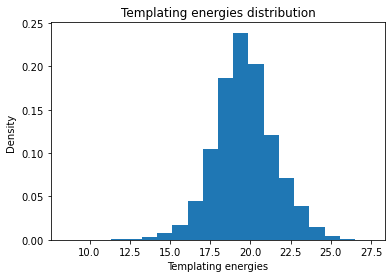

In [118]:
# idxmin = df.groupby(['Zeolite', 'InchiKey']).idxmin()
# df.iloc[0]["Competition (SiO2)"]

# pd.unique(df["Zeolite"])  # -> 209 zeolites...
# pd.unique(df["SMILES"])  # -> 1194 smiles
import pdb


def construct_column_count_histogram(col: str, df: pd.DataFrame, raw=False, n_bins=20):
    if raw:
        histogram_by_count = df[col]
    else:
        col_vals = pd.unique(df[col])
        histogram_by_count = {}
        for val in col_vals:
            count = len(df.loc[df[col] == val])
            histogram_by_count[count] = histogram_by_count.get(count, 0) + 1
    plt.hist(histogram_by_count, bins=n_bins, density=True)
    # plt.ylabel("# unique " + col)
    # plt.title("Histogram of " + col + " binned by templating energies")
    # plt.xlabel("# templating energies")
    plt.ylabel("Density ")
    plt.title("Templating energies distribution")
    plt.xlabel("Templating energies")
    print(
        "total cells: ",
        sum([count * instances for count, instances in histogram_by_count.items()]),
    )


# construct_column_count_histogram("Zeolite", df)
# construct_column_count_histogram("Ligand formula", df)
construct_column_count_histogram("Templating", df, raw=True)

# np.std(df['Templating'].dropna())
# np.mean(df['Templating'].dropna())
# np.median(df['Templating'].dropna())
# np.var(df['Templating'].dropna())



total not na cells: 112421


<ipython-input-196-1280a05451a0>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
<ipython-input-196-1280a05451a0>:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig("svd_scree_plot.png", dpi=150, figsize=(8, 6))


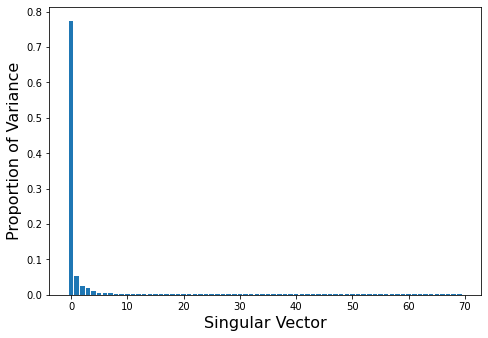

<ipython-input-196-1280a05451a0>:50: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(color="white")


reconstructed_matrix_k1 :  50.77266794581489
reconstructed_matrix_k5 :  21.959019357511256
reconstructed_matrix_k70 :  5.396687542649654
reconstructed_matrix_k209 :  3.710720048063188e-27


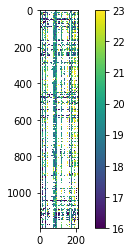

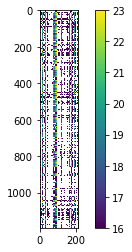

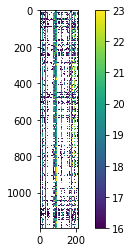

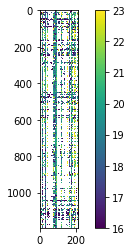

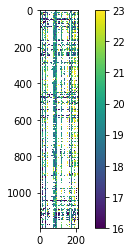

In [196]:
matrix = df.pivot(index="SMILES", columns="Zeolite", values="Templating")
print("total not na cells:", matrix.notna().sum().sum())  # 17587 what gives?

M = matrix.to_numpy()


def create_binary_mask(m, mask_nans=True, mask_zeros=False):
    def cast_bool_to_int(m):
        return np.array([1.0 if c else 0.0 for c in m])

    def create_bool_mask(m, mask_nans, mask_zeros):
        nan_mask = (
            np.invert(np.isnan(m)) if mask_nans else np.full(m.shape, True, dtype=bool)
        )
        zero_mask = m == 1 if mask_zeros else np.full(m.shape, True, dtype=bool)
        return np.logical_and(nan_mask, zero_mask,)

    return np.array(
        [cast_bool_to_int(r) for r in create_bool_mask(m, mask_nans, mask_zeros)]
    )


def invert_binary_mask(m):
    return np.logical_not(m).astype(int)


mask = create_binary_mask(M)


def plot_top_k_singular_values(var_explained, top_k=70):
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.bar(range(top_k), var_explained[0:top_k])
    plt.xlabel("Singular Vector", fontsize=16)
    plt.ylabel("Proportion of Variance", fontsize=16)
    plt.tight_layout()
    plt.savefig("svd_scree_plot.png", dpi=150, figsize=(8, 6))
    plt.show()


M = np.nan_to_num(M)
U, s, V = np.linalg.svd(M)
var_explained = np.round(s ** 2 / np.sum(s ** 2), decimals=3)
plot_top_k_singular_values(var_explained)


def plot_matrix(M, mask, file_name, vmin=16, vmax=23):
    fig, ax = plt.subplots()
    cmap = mpl.cm.get_cmap()
    cmap.set_bad(color="white")
    if mask is not None:
        inverted_mask = invert_binary_mask(mask)
        masked_M = np.ma.masked_where(inverted_mask, M)
    else:
        masked_M = M
    im = ax.imshow(masked_M, interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(im)
    fig.savefig(file_name + ".png", dpi=150)


def calc_MSE(M, M_star, mask):
    total_error = 0.0
    total_count = 0.0
    for x, y in np.ndindex(mask.shape):
        if mask[x, y] == 0:
            continue
        total_error += (M[x, y] - M_star[x, y]) ** 2
        total_count += 1
    return total_error / total_count


def reconstruct_M(U, s, V, num_components):
    M_star = (
        np.matrix(U[:, :num_components])
        * np.diag(s[:num_components])
        * np.matrix(V[:num_components, :])
    )
    return M_star


def run_SVD(M, mask, file_name, num_components):
    M = np.nan_to_num(M)
    U, s, V = np.linalg.svd(M)
    M_star = reconstruct_M(U, s, V, num_components)

    plot_matrix(M_star, mask, file_name)
    mse_k1 = calc_MSE(M, M_star, mask)
    print(file_name, ": ", mse_k1)


plot_matrix(M, mask, "matrix")
run_SVD(
    M=M, mask=mask, file_name="reconstructed_matrix_k1", num_components=1,
)
run_SVD(
    M=M, mask=mask, file_name="reconstructed_matrix_k5", num_components=5,
)
run_SVD(
    M=M, mask=mask, file_name="reconstructed_matrix_k70", num_components=70,
)
run_SVD(
    M=M, mask=mask, file_name="reconstructed_matrix_k209", num_components=209,
)



In [205]:
# Divide M into train and test...
import random

random.seed(10)

train_ratio = 0.5
train_mask = np.zeros(mask.shape)
for x, y in np.ndindex(mask.shape):
    if mask[x, y]:
        train_mask[x, y] = 1 if random.random() <= train_ratio else 0

test_mask = mask - train_mask
print("total #? ", np.count_nonzero(mask))
print("train #? ", np.count_nonzero(train_mask))
print("test #? ", np.count_nonzero(test_mask))



total #?  112421
train #?  56399
test #?  56022


total mse?  0.6913767391729397  train_mse?  0.0007581051115466633  test_mse?  1.3866428907281927


<ipython-input-201-d7e1ecb03ae9>:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(color="white")


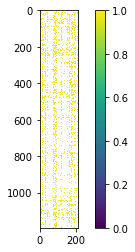

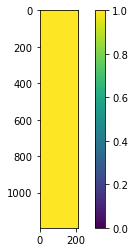

In [206]:
from matrix_completion import (
    nuclear_norm_solve,
    svt_solve,
)  # nuclear_norm_solve# svt_solve, calc_unobserved_rmse

# taken from https://pypi.org/project/matrix-completion/
# which -a pip
# /opt/anaconda3/bin/pip install matrix-completion
# /opt/anaconda3/bin/pip install cvxpy

# okay let's try svt_solve first...

# M = np.nan_to_num(M)
M_hat = nuclear_norm_solve(M, train_mask)

total_mse = calc_MSE(M, M_hat, mask)
train_mse = calc_MSE(M, M_hat, train_mask)
test_mse = calc_MSE(M, M_hat, test_mask)
print("total mse? ", total_mse, " train_mse? ", train_mse, " test_mse? ", test_mse)


plot_matrix(M_hat, train_mask, "nuclear_norm_matrix_with_mask")
plot_matrix(M_hat, None, "nuclear_norm_matrix_without_mask")



In [207]:
total_mse = calc_MSE(M, M_hat, mask)
train_mse = calc_MSE(M, M_hat, train_mask)
test_mse = calc_MSE(M, M_hat, test_mask)
print("total mse? ", total_mse, " train_mse? ", train_mse, " test_mse? ", test_mse)

def plot_matrix(M, mask, file_name, vmin=16, vmax=23):
    fig, ax = plt.subplots()
    cmap = mpl.cm.get_cmap()
    cmap.set_bad(color="white")
    if mask is not None:
        inverted_mask = invert_binary_mask(mask)
        masked_M = np.ma.masked_where(inverted_mask, M)
    else:
        masked_M = M
    im = ax.imshow(masked_M, interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    fig.colorbar(im)
    fig.savefig(file_name + ".png", dpi=150)
plot_matrix(M_hat, train_mask, "nuclear_norm_matrix_with_mask", vmin=16, vmax=23)
plot_matrix(M_hat, None, "nuclear_norm_matrix_without_mask", vmin=16, vmax=23)


total mse?  0.6913767391729397  train_mse?  0.0007581051115466633  test_mse?  1.3866428907281927


TypeError: plot_matrix() got an unexpected keyword argument 'vmin'

total not na cells: 112426
#non zero: 2102


<ipython-input-196-1280a05451a0>:50: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  cmap.set_bad(color="white")


total mse:  0.00037108784083513213


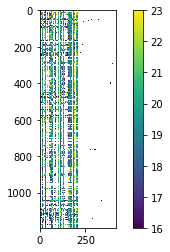

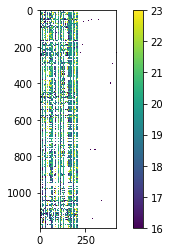

In [198]:
literature_matrix = df.pivot(index="SMILES", columns="Zeolite", values="In literature?")
print("total not na cells:", literature_matrix.notna().sum().sum())

lit_M = literature_matrix.to_numpy()
lit_mask = create_binary_mask(lit_M, True, True)
# Total 2102 non zero lit cells... very sparse very sparse.
print("#non zero:", np.count_nonzero(np.nan_to_num(lit_M)))

concatted_M = np.concatenate((M, lit_M), axis=1)
concatted_mask = np.concatenate((mask, lit_mask), axis=1)
plot_matrix(concatted_M, concatted_mask, "lit_matrix")


concatted_M_hat = nuclear_norm_solve(concatted_M, concatted_mask)
plot_matrix(concatted_M_hat, concatted_mask, "lit_matrix_computed", vmin=0, vmax=1)
total_mse = calc_MSE(concatted_M, concatted_M_hat, concatted_mask)
print("total mse: ", total_mse)

test_concatted_mask = np.concatenate((np.zeros(mask.shape), lit_mask), axis=1)
test_concatted_mse = calc_MSE(concatted_M, concatted_M_hat, test_concatted_mask)
print("test_concatted_mse: ", test_concatted_mse)

